In [65]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
from cftime import DatetimeNoLeap

## Import data

In [70]:
fp = 'data/ERA-Interim/ERA-Interim-AFR_0.4x0.4_*.nc'

all_files = glob.glob(fp)
all_files.sort()
print("Files found")

dset = xr.open_mfdataset(all_files)
print("Dataset created")

Files found
Dataset created


In [141]:
dset['slhf']

<xarray.DataArray 'slhf' (time: 132, latitude: 223, longitude: 216)>
dask.array<concatenate, shape=(132, 223, 216), dtype=float32, chunksize=(36, 223, 216), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.6 -24.2 -23.8 ... 60.2 60.6 61.0
  * latitude   (latitude) float32 42.8 42.4 42.0 41.6 ... -45.2 -45.6 -46.0
  * time       (time) datetime64[ns] 2016-01-01 ... 2019-08-02
Attributes:
    units:          J m**-2
    long_name:      Surface latent heat flux
    standard_name:  surface_upward_latent_heat_flux

## Daily mean from 3 ranges forecast

"**Monthly means of daily forecast accumulations**

Monthly means of daily forecast accumulations are produced for the accumulated surface and single level fields by averaging the twice daily forecasts (from 00 and 12 UTC) over the month, for the forecast ranges of 0-12 hours, 12-24 hours and 24-36 hours, and then scaling the results to have units “per day”." (ERA-Interim Archive documentation 2011)

So we average rolling over 3 datapoints in time:

In [128]:
def rolling_daily(ds):
    # Rolling mean over the window of 3 datapoints
    ds_rolled = ds.rolling(time=3, center=True).mean()
    # Select the middle datapoints over the groups of 3
    index_sel = [t*3+1 for t in range(44)]
    ds_new = ds_rolled.isel(time=index_sel)
    # Convert date
    #dates = list(ds_new.time.values + np.timedelta64(14, 'D'))   
    #ds_new = ds_new.assign_coords({'time':('time', dates, ds.time.attrs)})
    months = ds_new.time.dt.month.values
    years = ds_new.time.dt.year.values
    dates = [DatetimeNoLeap(year, month, 15) for year, month in zip(years, months)]
    ds_new = ds_new.assign_coords({'time':('time', dates, ds.time.attrs)})
    return ds_new
ds_prefix = rolling_daily(dset)

In [129]:
#ds['slhf'].head().values
#dset['slhf'].head().values

## Fix units and names

Latent heat flux is J/m2.

"The monthly means of daily forecast accumulations include all relevant forecasts that have an accumulation period in the month and so represent accumulations for the entire month at the particular forecast range. Since the hydrological parameters are in units of “m of water per day”, they should be multiplied by 1000 to convert to kgm-2day-1 or to mmday-1. Energy (turbulent and radiative) and momentum fluxes should be divided by 86400 seconds (24 hours) to convert to the commonly used units of Wm-2 and Nm-2, respectively." (ERA-Interim Archive documentation 2011)

In [131]:
def fix_names(ds):
    return ds.rename(dict(latitude='lat', longitude='lon', slhf = 'hfls', tp ='pr', e='ev'))
    
def fix_units(ds):
    ds_ = ds.copy(deep=True)
    
    for var in list(ds_.keys()):

        if var == 'hfls':
            ds_[var].values = ds_[var].values/86400. # Change unit from J/m2 to W/m2
            ds_[var].attrs["units"] = "W m-2"
        
        elif var == 'pr' or var == 'ro' or var == 'ev':
            ds_[var].values = ds_[var].values*1000./86400. # Change unit from m to kg/m2/day and then to kg/m2/s
            ds_[var].attrs["units"] = "kg m-2 s-1"
        
    return ds_

ds = fix_units(fix_names(ds_prefix))

In [135]:
for var in ['hfls','pr','ro','ev']:
    ds[var].to_netcdf('data/ERA-Interim-processed/'+var+'_ERA-Interim_AFR_0.4x0.4_201601-201908.nc')

In [ ]:
ds_ = ds.copy(deep=True)
    
    for var in list(ds_.keys()):
        
        if var == "SFisoprene" or var == "SFmonoterp":
            ds_[var].values = ds_[var].values*(1e+6*(60.*60.*24.*365.)) # Change unit from kg/m2/s to mg/m2/y
            #Note: this unit makes sense when a yearly value is shown, remember the output is monthly -> mean over the year or convert into month/day (/12, /365)
            ds_[var].attrs["units"] = "mg/m$^2$/y"
            
        elif var == "SOA_A1" or var == "SOA_NA":
            ds_[var].values = ds_[var].values*1e+9 # Change unit from kg/kg to $\mu$g/kg
            ds_[var].attrs["units"] = "$\mu$g/kg"
            
        elif var == "cb_SOA_A1" or var == "cb_SOA_NA" or var == "cb_SOA_A1_OCW" or var == "cb_SOA_NA_OCW":
            ds_[var].values = ds_[var].values*1e+6 # Change unit from kg/m2 to mg/m2
            ds_[var].attrs["units"] = "mg/m$^2$"
            
        elif var == "ACTNL":
            ds_[var].values = ds_[var].values*1e-6 # Change unit from m-3 to cm-3
            ds_[var].attrs["units"] = "cm$^{-3}$"
            
        elif var == "N_AER":
            ds_[var].attrs["units"] = "cm$^{-3}$" # Set unit to cm-3
            
        elif var == "CDNUMC":
            ds_[var].values = ds_[var].values*1e-10 # Change unit from 1/m2 to 1e6 cm-2
            ds_[var].attrs["units"] = "1e6 cm$^{-2}$"
            
        elif var == "CLDHGH" or var == "CLDLOW" or var == "CLDMED" or var == "CLDMED":
            ds_[var].values = ds_[var].values*1e+3 # Change unit from fraction to g/kg
            ds_[var].attrs["units"] = "g/kg"
            
        elif var == "CLDLIQ":
            ds_[var].values = ds_[var].values*1e+6 # Change unit from kg/kg to mg/kg
            ds_[var].attrs["units"] = "mg/kg"
            
        elif var == "TGCLDLWP":
            ds_[var].values = ds_[var].values*1e+3 # Change unit from kg/m2 to g/m2
            ds_[var].attrs["units"] = "g/m$^2$"
            
        elif var == "QFLX_EVAP_TOT":
            ds_[var].values = ds_[var].values*60*60*24 # Change unit from mm H2O/s to mm H2O/day
            ds_[var].attrs["units"] = "mm/day"
            
        elif var == "FLNT" or var == "FSNT" or var == "FLNT_DRF" or var == "FLNTCDRF" or var == "FSNT_DRF" or var == "FSNTCDRF" or var =="LHFLX" or var =="SHFLX":
            ds_[var].attrs["units"] = "W/m$^2$" # Change unit from W/m^2 to W/m2, like the other radiative fluxes
         
        else:
            continue
            
        #print(var, "-", ds_[var].attrs["long_name"], ":")
        #print(ds_[var].attrs["units"])
    print("Fix units completed")

In [74]:
    
    def fix_units(ds):
    if var == 
    rename(name_dict=None ds_new

<xarray.Dataset>
Dimensions:    (longitude: 216, latitude: 223, time: 44)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.6 -24.2 -23.8 ... 60.2 60.6 61.0
  * latitude   (latitude) float32 42.8 42.4 42.0 41.6 ... -45.2 -45.6 -46.0
  * time       (time) object 2016-01-15 00:00:00 ... 2019-08-15 00:00:00
Data variables:
    slhf       (time, latitude, longitude) float64 dask.array<chunksize=(13, 223, 216), meta=np.ndarray>
    e          (time, latitude, longitude) float64 dask.array<chunksize=(13, 223, 216), meta=np.ndarray>
    ro         (time, latitude, longitude) float64 dask.array<chunksize=(13, 223, 216), meta=np.ndarray>
    tp         (time, latitude, longitude) float64 dask.array<chunksize=(13, 223, 216), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-26 09:22:23 GMT by grib_to_netcdf-2.26.0: grib_to_n...

In [52]:
ds_new = ds.isel(time=slice(0,44))

dates = []; t = 0; index_sel = []
for i in range(44):
    dates.append(ds.time.values[t]  + np.timedelta64(14, 'D'))
    index_sel.append(t)
    t = t + 3

ds_new = ds_new.assign_coords({'time':('time', dates, ds_new.time.attrs)})


In [49]:
da = ds['slhf']
da_rolled = da.rolling(time=3).mean()

In [55]:
da_rolled.isel(time=index_sel)

<xarray.DataArray 'slhf' (time: 44, latitude: 223, longitude: 216)>
dask.array<getitem, shape=(44, 223, 216), dtype=float64, chunksize=(13, 223, 216), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.6 -24.2 -23.8 ... 60.2 60.6 61.0
  * latitude   (latitude) float32 42.8 42.4 42.0 41.6 ... -45.2 -45.6 -46.0
  * time       (time) datetime64[ns] 2016-01-01 2016-02-01 ... 2019-08-01
Attributes:
    units:          J m**-2
    long_name:      Surface latent heat flux
    standard_name:  surface_upward_latent_heat_flux

/Users/adelezaini/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


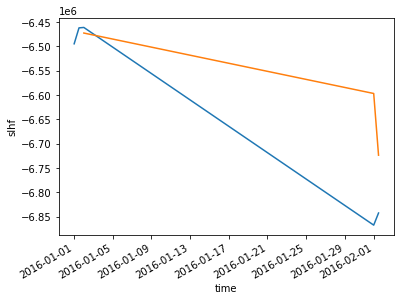

In [103]:
da.mean(['latitude','longitude']).isel(time=slice(0,5)).plot()
da_rolled.mean(['latitude','longitude']).isel(time=slice(0,5)).plot()

2016-01-01T00:00:00.000000000 - 2016-01-01T12:00:00.000000000


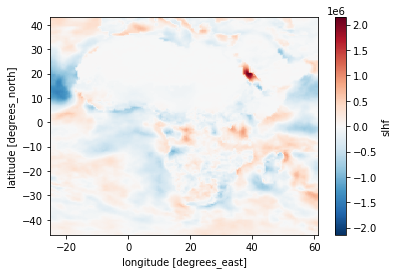

2016-01-01T12:00:00.000000000 - 2016-01-02T00:00:00.000000000


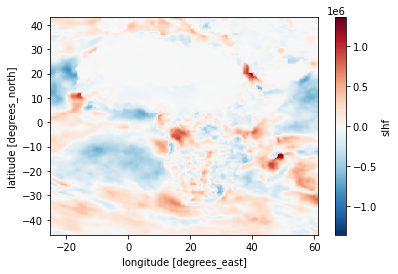

2016-01-01T00:00:00.000000000 - 2016-01-01T12:00:00.000000000


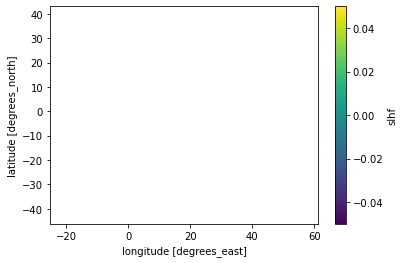

2016-01-01T12:00:00.000000000 - 2016-01-02T00:00:00.000000000


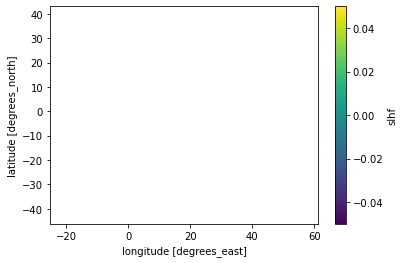

In [51]:
for t in [0,1]:
    diff = da.isel(time=t)-da.isel(time=(t+1))
    print(da.isel(time=t).time.values, '-', da.isel(time=t+1).time.values )
    diff.plot(); plt.show()
    
for t in [0,1]:
    diff = da_rolled.isel(time=t)-da_rolled.isel(time=(t+1))
    print(da_rolled.isel(time=t).time.values, '-', da_rolled.isel(time=t+1).time.values )
    diff.plot(); plt.show()

In [37]:
ds.time.dt.day
#“year”, “month”, “day”, “hour”, “minute”, “second”, 
#“microsecond”, “season”, “dayofyear”, “dayofweek”, and “days_in_month”

<xarray.DataArray 'day' (time: 132)>
array([1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2,
       1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-01T12:00:00 ... 2019-08-02

In [31]:
ds['slhf'].groupby("time.monthofyear")

AttributeError: 'DatetimeAccessor' object has no attribute 'monthofyear'

In [ ]:
da.groupby("time.dayofyear") - da.groupby("time.dayofyear").mean("time")

In [ ]:
def fix_cam_time(ds, timetype = 'datetime64'):
    # Inspired by Marte Sofie Buraas / Ada Gjermundsen
    # Adampted for cam and clm output and to have time in DatetimeNoLeap or in 'datetime64' types (default)
    
    """ NorESM raw h0 files has incorrect time variable output,
    thus it is necessary to use time boundaries to get the correct time
    If the time variable is not corrected, none of the functions involving time
    e.g. yearly_avg, seasonal_avg etc. will provide correct information
    Source: https://noresm-docs.readthedocs.io/en/latest/faq/postp_plotting_faq.html
    
    Parameters
    ----------
    ds : xarray.DaraSet
    type: string, type of ds.time
    
    Returns
    -------
    ds : xarray.DaraSet with corrected time
    """

    # Make compatible variable names for CAM and CLM (CLM names converted to CAM)
    ds_ = ds.copy(deep=True)
    if 'time_bounds' in list(ds_.data_vars): 
        ds_ = ds_.rename_vars(dict(time_bounds='time_bnds'))
        ds_ = ds_.rename_dims(dict(hist_interval='nbnd'))

    # monthly data: refer data to the 15th of the month
    if timetype == 'DatetimeNoLeap':
        from cftime import DatetimeNoLeap

        months = ds_.time_bnds.isel(nbnd=0).dt.month.values
        years = ds_.time_bnds.isel(nbnd=0).dt.year.values
        dates = [DatetimeNoLeap(year, month, 15) for year, month in zip(years, months)]
      
    elif timetype == 'datetime64':
        dates = list(ds_.time_bnds.isel(nbnd=0).values + np.timedelta64(14, 'D'))
      
    else:
        raise ValueError("time type not supported. Choose 'DatetimeNoLeap' or 'datetime64'")
      
    ds = ds.assign_coords({'time':('time', dates, ds.time.attrs)})
    return ds

In [4]:
fn = 'data/ERA-Interim/ERA-Interim-AFR_0.4x0.4_2016.nc'
obs_2016 = xr.open_dataset(fn)

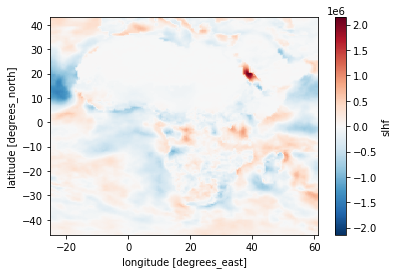

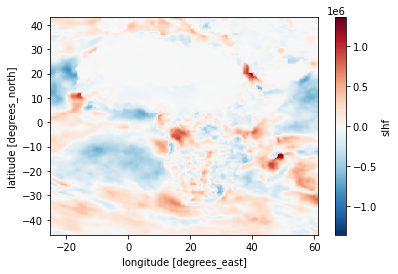

In [15]:
for t in [0,1]:
    diff = obs_2016['slhf'].isel(time=t)-obs_2016['slhf'].isel(time=(t+1))
    diff.plot(); plt.show()

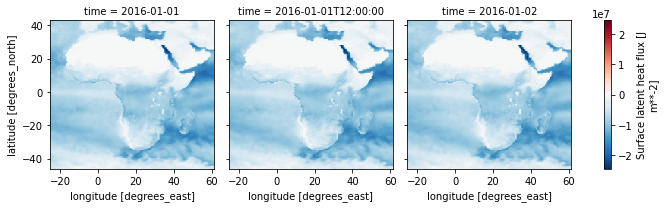

In [16]:
obs_2016['slhf'].isel(time=[0,1,2]).plot(col='time')

In [17]:
fn = '/Users/adelezaini/Desktop/master-thesis/processed-data/postprocessing/CTRL_BVOC_20082012.nc'
ctrl = xr.open_dataset(fn)
ctrl

<xarray.Dataset>
Dimensions:     (time: 60, lat: 96, lon: 144, nbnd: 2, lev: 32, ilev: 33)
Coordinates:
  * ilev        (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lev         (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time        (time) datetime64[ns] 2008-01-15 2008-02-15 ... 2012-12-15
Dimensions without coordinates: nbnd
Data variables: (12/13)
    LANDFRAC    (time, lat, lon) float32 ...
    GRIDAREA    (time, lat, lon) float32 ...
    gw          (time, lat) float64 ...
    date        (time) int32 ...
    time_bnds   (time, nbnd) datetime64[ns] ...
    P0          (time) float64 ...
    ...          ...
    hybm        (time, lev) float64 ...
    PS          (time, lat, lon) float32 ...
    hyai        (time, ilev) float64 ...
    hybi        (time, ilev) float64 ...
    SFisoprene  (time, lat, lon) float32 ...
    SFmonoterp  (time, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              CTRL_2000_f19_f19
    logname:           adelez
    host:              
    initial_file:      CTRL_2000_spinup_f19_f19.cam.i.0036-01-01-00000.nc
    topography_file:   /cluster/shared/noresm/inputdata/noresm-only/inputForN...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1